<h1 style="text-align: center;">WSI - ćwiczenie 7. - Modele Bayesowskie</h1>

In [1]:
from MCMC import MCMC
from bayes_network import BayesNetwork, Node
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import time

### Stworzenie sieci Bayesa:


In [2]:
burglary = Node("Burglary")
earthquake = Node("Earthquake")
alarm = Node("Alarm", parents=[burglary, earthquake])
john_calls = Node("JohnCalls", parents=[alarm])
mary_calls = Node("MaryCalls", parents=[alarm])

bayes_network = BayesNetwork([burglary, earthquake, alarm, john_calls, mary_calls])

### Nadanie wartości prawdopodobieństw:

In [3]:
PROBABILITIES = {
    "Burglary": 0.01,
    "Earthquake": 0.02,
    "Alarm" : {
        (True, True): 0.95,
        (True, False): 0.94,
        (False, True): 0.29,
        (False, False): 0.001
    },
    "JohnCalls": {
        (True,): 0.90,
        (False,): 0.05
    },
    "MaryCalls": {
        (True,): 0.70,
        (False,): 0.01
    }
}

### Przykład działania algorytmu:

In [4]:
evidence = {
    "JohnCalls": False,
    "MaryCalls": False,
}

query = {
    "Earthquake": False,
}

mcmc = MCMC(bayes_network, PROBABILITIES)
results = mcmc.inference(evidence, query, 10000)
print("Prawdobodobieństwo, że było trzęsienie ziemi jeśli John zadzwonił a Marry nie: ", results.get(earthquake)[True])

Prawdobodobieństwo, że było trzęsienie ziemi jeśli John zadzwonił a Marry nie:  0.0077


### Badanie wpływu liczby iteracji na wynik:

Każdy eksperyment przeprowadzę:
 - z takimi samymi zapytaniami i dowodami
 - dla liczby iteracji od 1000 do 100000
 - dla każdej wartości liczby iteracji eksperyment przeprowadzę 10 razy

In [5]:
evidence = {
    "JohnCalls": True,
    "MaryCalls": False,
}

query = {
    "Earthquake": True,
}

NUMBER_OF_ITERATIONS = np.arange(1000, 100000, 5000)
TESTS = 10
iter_data = pd.DataFrame()

for n_iters in tqdm(NUMBER_OF_ITERATIONS):
    for _ in range(TESTS):
        _evidence = evidence.copy()
        results = mcmc.inference(_evidence, query, n_iters)
        iter_series = pd.Series({
            'n_iters': n_iters,
            'prob_true': results.get(earthquake)[True]
        })
        iter_data = pd.concat([iter_data, iter_series.to_frame(1).T])

  0%|          | 0/20 [00:00<?, ?it/s]

 70%|███████   | 14/20 [00:21<00:14,  2.48s/it]

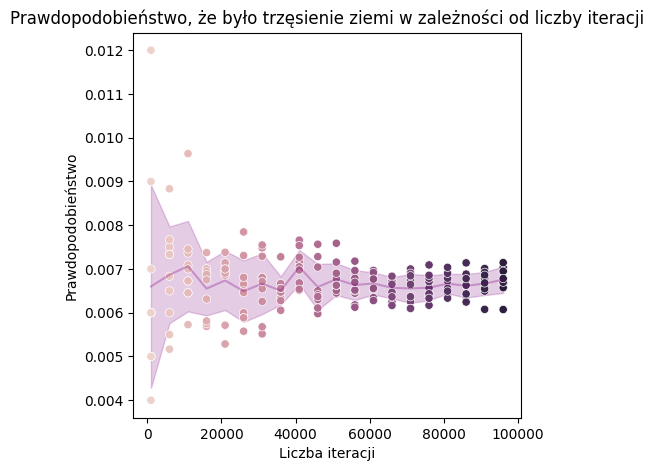

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(data=iter_data, x='n_iters', y='prob_true', ax=ax, errorbar='sd', color='purple', alpha=0.3)
sns.scatterplot(data=iter_data, x='n_iters', y='prob_true', ax=ax, hue='n_iters', legend=False)
ax.set_xlabel('Liczba iteracji')
ax.set_ylabel('Prawdopodobieństwo')
plt.title('Prawdopodobieństwo, że było trzęsienie ziemi w zależności od liczby iteracji')
plt.show()

### Wnioski:
 - zauważamy, że im więcej iteracji algorytmu tym osiągamy większą dokładność wyniku

### Badanie wpływu liczby iteracji na czas obliczeń:

In [ ]:
evidence = {
    "JohnCalls": True,
    "MaryCalls": False,
}

query = {
    "Earthquake": True,
}

NUMBER_OF_ITERATIONS = np.arange(1000, 100000, 5000)
TESTS = 10
time_data = pd.DataFrame()

for n_iters in tqdm(NUMBER_OF_ITERATIONS):
    for _ in range(TESTS):
        _evidence = evidence.copy()
        start = time.time()
        results = mcmc.inference(_evidence, query, n_iters)
        end = time.time()
        delta = end - start
        time_series = pd.Series({
            'n_iters': n_iters,
            'time': delta
        })
        time_data = pd.concat([time_data, time_series.to_frame(1).T])

100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


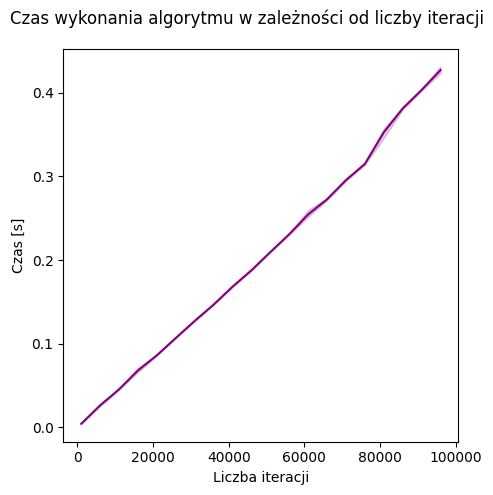

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(data=time_data, x='n_iters', y='time', ax=ax, color='purple')
fig.suptitle('Czas wykonania algorytmu w zależności od liczby iteracji')
ax.set_xlabel('Liczba iteracji')
ax.set_ylabel('Czas [s]')
fig.tight_layout()
plt.show()

### Wnioski:
 - czas działania algorytmu jest proporcjonalny do liczby iteracji
 - taki wynik będziemy otrzymywać dla sieci Bayesa o niedużej ilości węzłów i relacji rodzic-dziecko, ponieważ poza zliczaniem iloczynu prawdopodobieństw rodziców dzieci danego węzła, wszystkie inne operacje wykonywane podczas jednej iteracji mają stałą złożoność obliczeniową